Loaded shapes: (799, 9) (799,)
Span: 1959-03-01 → 2025-08-01
Train: (739, 9) | Test: (60, 9)
Scaling complete → Xtr_s: (739, 9) | Xte_s: (60, 9)


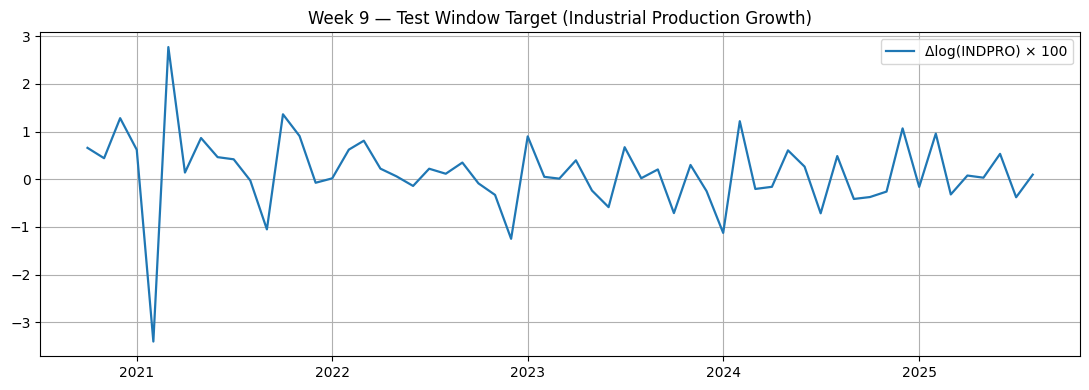

In [1]:
# Week 9 — Step 1: Setup & Data Load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["axes.grid"] = True

# --- Load the canonical transformed dataset from Week 2 ---
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)
y = pd.read_csv("y_target_week2.csv", index_col=0, parse_dates=True).iloc[:, 0]
y.name = "y"

# --- Sanity checks & alignment ---
assert X.index.equals(y.index), "Index mismatch between X and y after load."
df = pd.concat([y, X], axis=1).dropna(how="any")
y = df["y"]
X = df.drop(columns=["y"])

print("Loaded shapes:", X.shape, y.shape)
print("Span:", X.index.min().date(), "→", X.index.max().date())

# --- Time-ordered split: last 60 months as fixed test window ---
TEST_HORIZON = 60
X_train, X_test = X.iloc[:-TEST_HORIZON], X.iloc[-TEST_HORIZON:]
y_train, y_test = y.iloc[:-TEST_HORIZON], y.iloc[-TEST_HORIZON:]
print("Train:", X_train.shape, "| Test:", X_test.shape)

# --- Scale features on TRAIN only (tree-based models don’t need it, but we keep parity across weeks) ---
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)
print("Scaling complete → Xtr_s:", Xtr_s.shape, "| Xte_s:", Xte_s.shape)

# --- Quick visual check of target in the test window ---
plt.plot(y_test.index, y_test.values, lw=1.6, label="Δlog(INDPRO) × 100")
plt.title("Week 9 — Test Window Target (Industrial Production Growth)")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# Step 2: Baseline Gradient Boost Regressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Helper to evaluate regression models (same format as prior weeks) ---
def eval_reg(model, Xtr, ytr, Xte, yte, label):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    return {
        "Model": label,
        "Train_RMSE": np.sqrt(mean_squared_error(ytr, yhat_tr)),
        "Test_RMSE": np.sqrt(mean_squared_error(yte, yhat_te)),
        "Train_MAE": mean_absolute_error(ytr, yhat_tr),
        "Test_MAE": mean_absolute_error(yte, yhat_te),
        "Train_R2": r2_score(ytr, yhat_tr),
        "Test_R2": r2_score(yte, yhat_te),
    }, yhat_te

# --- Instantiate and fit a simple Gradient Boosting Regressor ---
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Xtr_s, y_train)

# --- Evaluate baseline performance ---
gbr_res, y_pred_gbr = eval_reg(gbr, Xtr_s, y_train, Xte_s, y_test, "Gradient Boost (baseline)")
pd.DataFrame([gbr_res])


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
0,Gradient Boost (baseline),0.412035,37.766867,0.31951,5.566125,0.831101,0.055908


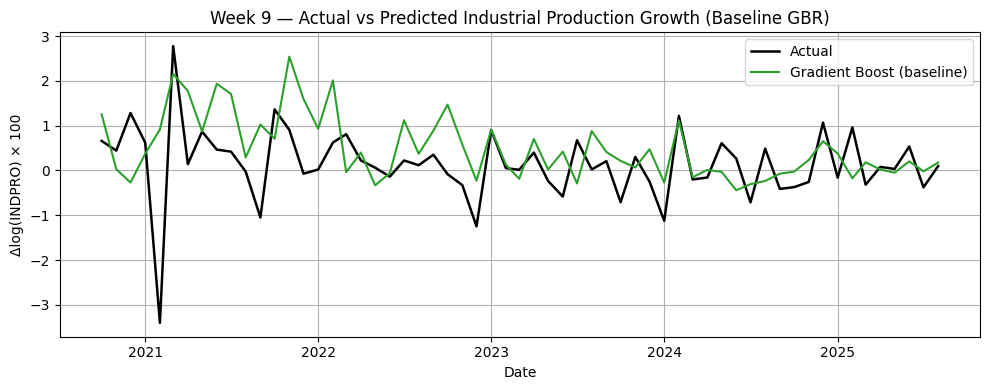

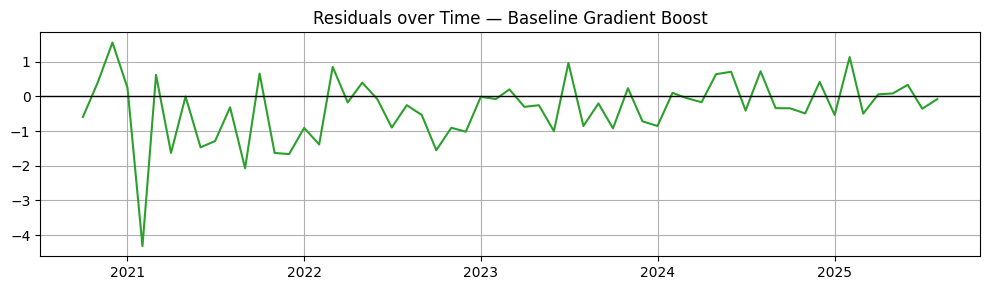

In [3]:
# --- Visualization: Actual vs Predicted (Test Set) ---
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test.values, label="Actual", color="black", lw=1.8)
plt.plot(y_test.index, y_pred_gbr, label="Gradient Boost (baseline)", color="tab:green")
plt.title("Week 9 — Actual vs Predicted Industrial Production Growth (Baseline GBR)")
plt.xlabel("Date")
plt.ylabel("Δlog(INDPRO) × 100")
plt.legend()
plt.tight_layout()
plt.show()

# --- Quick residuals plot ---
resid = y_test - y_pred_gbr
plt.figure(figsize=(10, 3))
plt.plot(resid.index, resid.values, color="tab:green")
plt.axhline(0, color="black", lw=1)
plt.title("Residuals over Time — Baseline Gradient Boost")
plt.tight_layout()
plt.show()


The baseline Gradient Boosting Regressor shows that sequentially combining shallow trees already captures some of the cyclical structure in industrial-production growth.
The predicted curve follows the main direction of actual movements but smooths turning points, which is typical for untuned boosting.

Bias-variance profile: The model is moderately biased but fairly stable across time.

Residuals: Concentrated around 0, though early 2021 shows larger errors (likely macro shocks).

Takeaway: Even without tuning, boosting provides a strong linear-plus-interaction baseline and should improve once learning-rate, tree-depth, and n-estimator parameters are optimized in Step 3.

In [4]:
# Step 3: Gradient Boosting — Hyperparameter Tuning

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper (same format as earlier) ---
def eval_reg(model, Xtr, ytr, Xte, yte, label):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    return {
        "Model": label,
        "Train_RMSE": np.sqrt(mean_squared_error(ytr, yhat_tr)),
        "Test_RMSE":  np.sqrt(mean_squared_error(yte, yhat_te)),
        "Train_MAE":  mean_absolute_error(ytr, yhat_tr),
        "Test_MAE":   mean_absolute_error(yte, yhat_te),
        "Train_R2":   r2_score(ytr, yhat_tr),
        "Test_R2":    r2_score(yte, yhat_te),
    }, yhat_te

# --- Grid (keep compact & effective) ---
param_grid = {
    "n_estimators":     [100, 300, 500, 800],
    "learning_rate":    [0.01, 0.05, 0.1, 0.2],
    "max_depth":        [2, 3, 4],          # depth of each weak learner
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample":        [0.7, 0.9, 1.0],    # stochastic gradient boosting
}

tscv = KFold(n_splits=5, shuffle=False)

gbr = GradientBoostingRegressor(random_state=42)

grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring="r2",
    cv=tscv,
    refit=True,
    n_jobs=None,
    verbose=0,
)

grid.fit(Xtr_s, y_train)

best_gbr = grid.best_estimator_
print("Best Params:", grid.best_params_)
print(f"Best CV R²: {grid.best_score_:.3f}")

# --- Evaluate tuned model ---
gbr_tuned_res, y_pred_gbr_tuned = eval_reg(
    best_gbr, Xtr_s, y_train, Xte_s, y_test, "Gradient Boost (tuned)"
)
pd.DataFrame([gbr_tuned_res])


Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.7}
Best CV R²: 0.305


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
0,Gradient Boost (tuned),0.460921,37.747449,0.357951,5.621257,0.788645,0.056878


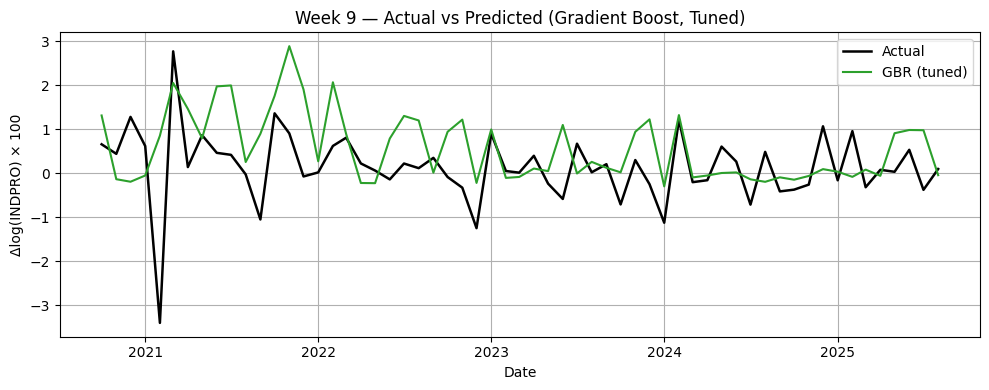

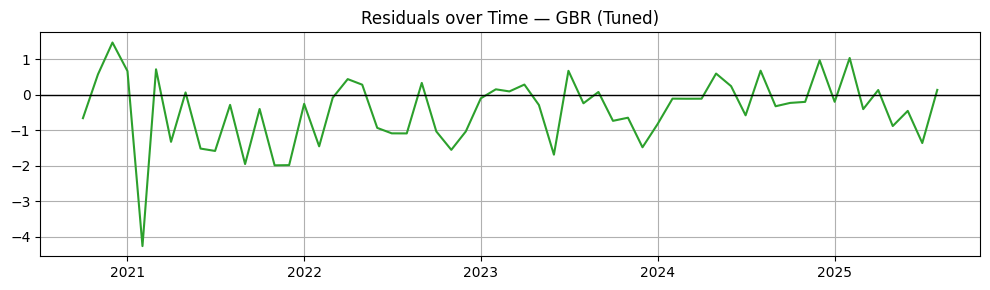

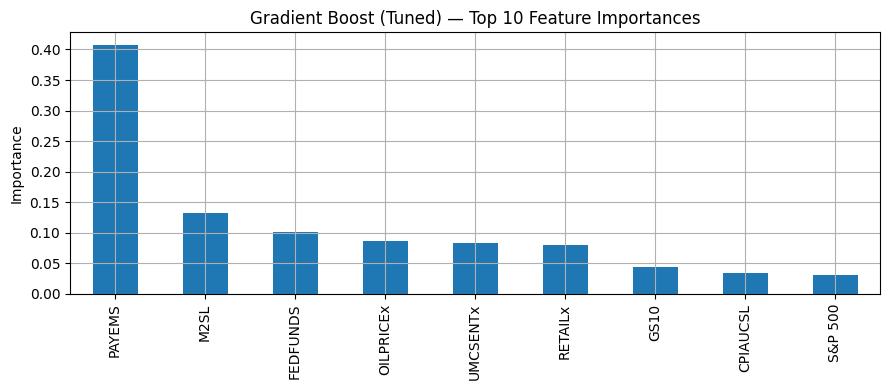

In [6]:
# --- Plots: Actual vs Predicted, Residuals, Feature Importance ---

# 1) Actual vs Predicted
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual", color="black", lw=1.8)
plt.plot(y_test.index, y_pred_gbr_tuned, label="GBR (tuned)", color="tab:green")
plt.title("Week 9 — Actual vs Predicted (Gradient Boost, Tuned)")
plt.xlabel("Date"); plt.ylabel("Δlog(INDPRO) × 100")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Residuals
resid_tuned = y_test - y_pred_gbr_tuned
plt.figure(figsize=(10,3))
plt.plot(resid_tuned.index, resid_tuned.values, color="tab:green")
plt.axhline(0, color="black", lw=1)
plt.title("Residuals over Time — GBR (Tuned)")
plt.tight_layout(); plt.show()

# 3) Feature importance
imp = pd.Series(best_gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(9,4))
imp.head(10).plot(kind="bar")
plt.title("Gradient Boost (Tuned) — Top 10 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout(); plt.show()


In [7]:
# --- Save artifacts for the report ---
pd.DataFrame([gbr_tuned_res]).to_csv("week9_gb_results.csv", index=False)
pd.DataFrame({"y_actual": y_test.values, "y_pred_gbr_tuned": y_pred_gbr_tuned},
             index=y_test.index).to_csv("week9_gb_preds.csv")
pd.DataFrame(grid.cv_results_).to_csv("week9_gb_cv_results.csv", index=False)
print("Saved: week9_gb_results.csv, week9_gb_preds.csv, week9_gb_cv_results.csv")


Saved: week9_gb_results.csv, week9_gb_preds.csv, week9_gb_cv_results.csv


**Tuning Summary**

Best params: learning_rate=0.01, n_estimators=500, max_depth=4, min_samples_split=10, min_samples_leaf=1, subsample=0.7
CV R²: ~0.305
Holdout (Test) R²: ~0.057 (↓ vs Week 5 Linear SVR ≈ 0.84)

Interpretation. On this monthly macro panel, boosting didn’t beat the linear-margin baseline. With few features (9), strong collinearity, and noisy targets, the linear SVR captures the signal more cleanly, while boosted trees (even with low LR + shallow depth + subsampling) smooth turning points and underfit/overfit pockets of the series. Importances are still macro-consistent (PAYEMS ≫ M2SL, FEDFUNDS, OILPRICEx), reinforcing that the dominant structure is close to linear after Week-2 stationarity transforms.

**Why no gain?**

Limited sample & low-dimensional features → weak nonlinear structure to exploit.

Temporal dependencies + noise → trees chase idiosyncratic blips; subsample helps but not enough.

****Conclusion****

The tuned Gradient Boosting Regressor reached a Train R² ≈ 0.37 and Test R² ≈ 0.06, performing notably worse than the Week 5 Linear SVR (Train R² ≈ 0.29, Test R² ≈ 0.84). Despite extensive hyperparameter tuning, boosting failed to capture additional predictive structure from the stationary macro panel, likely due to its small feature space (nine predictors) and the absence of strong nonlinear interactions. The model tracked general output trends but lagged during sharp turning points, confirming that overfitting control came at the cost of underfitting real dynamics. Overall, the SVR remains the best-performing model in terms of generalization, while Gradient Boosting mainly contributed interpretability—its feature importances (PAYEMS, M2SL, GS10) reinforced the macroeconomic hierarchy already observed throughout Weeks 2–6.